# Exercise 1

In [26]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import a4_utils
import math

a)

In [2]:
def hessian_points(img, sigma):
    g = a4_utils.gauss(sigma)
    d = a4_utils.gaussdx(sigma)

    Ix = a4_utils.convolve(img, g.T, d)
    Iy = a4_utils.convolve(img, g, d.T)
    Ixx = a4_utils.convolve(Ix, g.T, d)
    Iyy = a4_utils.convolve(Iy, g, d.T)
    Ixy = a4_utils.convolve(Ix, g, d.T)
 
    return Ixx*Iyy - Ixy ** 2

In [3]:
def nonmaxima_suppression_box(img):
    res = img.copy()
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # Change for different neighbourhood box sizes
            neighbourhood = [(x + i, y + j) for i in range(-1, 2) for j in range(-1, 2)]
            
            for x_n, y_n in neighbourhood:
                if x_n < 0 or y_n < 0 or x_n >= img.shape[0] or y_n >= img.shape[1]:
                    continue
                # suppress non-maximums
                if img[x, y] < img[x_n, y_n]:
                    res[x, y] = 0
    return res

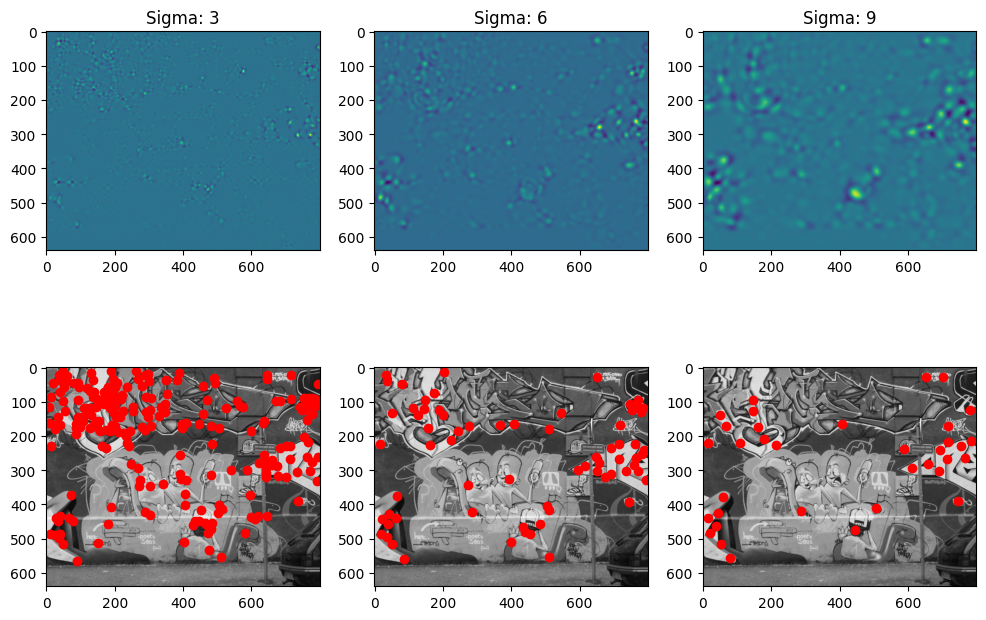

In [4]:
graf = cv2.cvtColor(cv2.imread('./data/graf/graf_a.jpg'), cv2.COLOR_BGR2RGB)
graf_gray = cv2.cvtColor(graf, cv2.COLOR_RGB2GRAY).astype('float64') / 255.0

tresh = 0.004
sigmas = [3, 6, 9]

plt.figure(figsize=(12, 8))
for i, sigma in enumerate(sigmas):
    hess = hessian_points(graf_gray, sigma)
    hess_sup = nonmaxima_suppression_box(hess)
    points = np.where(hess_sup > tresh)

    plt.subplot(2, 3, i + 1)
    plt.title(f"Sigma: {sigma}")
    plt.imshow(hess, cmap='viridis')
    plt.subplot(2, 3, i + 4)
    plt.imshow(graf_gray, cmap='gray')
    plt.scatter(points[1], points[0], color='red')

Q1: Algorithm dedects points with rapid changes in intensity. Sigma parameter effects sensitivity of the edge detection.

b)

In [5]:
def smooth(img, sigma_s):
    g2 = a4_utils.gauss(sigma_s)
    return a4_utils.convolve(img, g2, g2.T)

In [6]:
def harris_detector(img, sigma, sigma_s, alpha):
    g = a4_utils.gauss(sigma)
    d = a4_utils.gaussdx(sigma)

    Ix = a4_utils.convolve(img, g.T, d)
    Iy = a4_utils.convolve(img, g, d.T)
    
    C11 = smooth(Ix ** 2, sigma_s)
    C12 = smooth(Ix * Iy, sigma_s)
    C22 = smooth(Iy ** 2, sigma_s)
    d = C11*C22 - C12 ** 2 
    t = C11 + C22

    return d - alpha*t**2

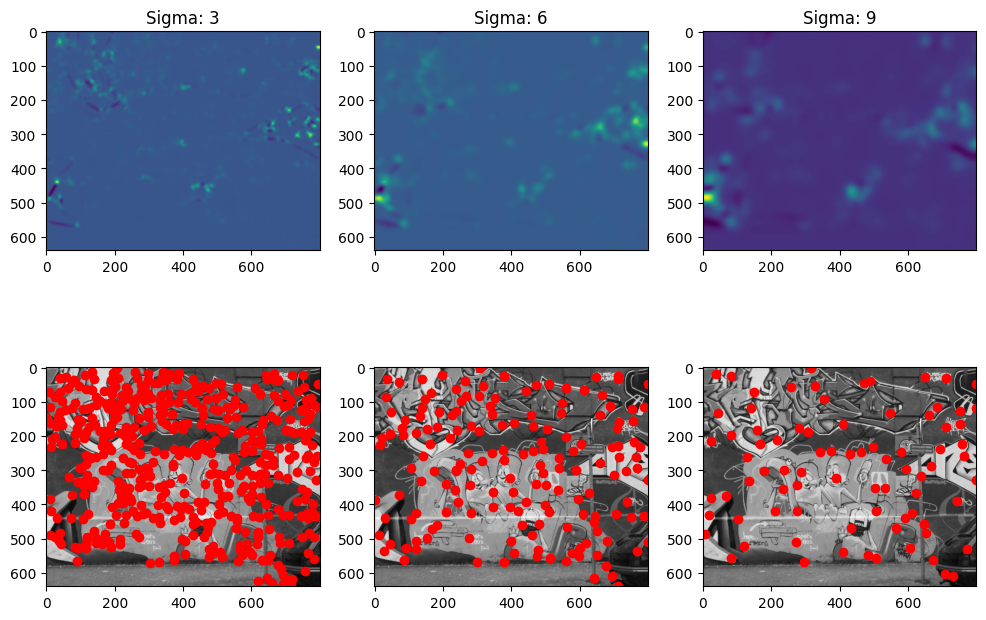

In [7]:
graf = cv2.cvtColor(cv2.imread('./data/graf/graf_a.jpg'), cv2.COLOR_BGR2RGB)
graf_gray = cv2.cvtColor(graf, cv2.COLOR_RGB2GRAY).astype('float64') / 255.0

tresh = 1e-6
sigmas = [3, 6, 9]
alpha = 0.06

plt.figure(figsize=(12, 8))
for i, sigma in enumerate(sigmas):
    harris = harris_detector(graf_gray, sigma, 1.6*sigma, alpha)
    harris_sup = nonmaxima_suppression_box(harris)
    points = np.where(harris_sup > tresh)

    plt.subplot(2, 3, i + 1)
    plt.title(f"Sigma: {sigma}")
    plt.imshow(harris, cmap='viridis')
    plt.subplot(2, 3, i + 4)
    plt.imshow(graf_gray, cmap='gray')
    plt.scatter(points[1], points[0], color='red')

# Exercise 2

a)

In [8]:
def suppressed_hessian_points(img, sigma=3, thresh=0.004):
    g = a4_utils.gauss(sigma)
    d = a4_utils.gaussdx(sigma)

    Ix = a4_utils.convolve(img, g.T, d)
    Iy = a4_utils.convolve(img, g, d.T)
    Ixx = a4_utils.convolve(Ix, g.T, d)
    Iyy = a4_utils.convolve(Iy, g, d.T)
    Ixy = a4_utils.convolve(Ix, g, d.T)

    hess_det = Ixx*Iyy - Ixy ** 2

    det_supp = np.where(hess_det > thresh, hess_det, 0)
    feature_points = nonmaxima_suppression_box(det_supp)
    
    return hess_det, feature_points

In [9]:
def hellinger_distance(h1, h2):
    dist = np.sqrt(0.5 * np.sum((np.sqrt(h1) - np.sqrt(h2)) ** 2))
    return dist

def find_correspondences(desc1, desc2):
    corr = []
    for i, d1 in enumerate(desc1):
        distances = [hellinger_distance(d1, d2) for d2 in desc2]
        best_match = np.argmin(distances)
        corr.append([i, best_match])
    return corr

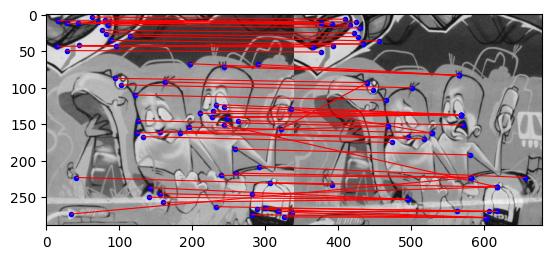

In [10]:
graf_a = cv2.imread("./data/graf/graf_a_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
graf_b = cv2.imread("./data/graf/graf_b_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0

Y1, X1 = np.nonzero(suppressed_hessian_points(graf_a, 3, 0.003)[1])
Y2, X2 = np.nonzero(suppressed_hessian_points(graf_b, 3, 0.003)[1])

desc1 = a4_utils.simple_descriptors(graf_a, Y1, X1)
desc2 = a4_utils.simple_descriptors(graf_b, Y2, X2)

corr = find_correspondences(desc1, desc2)

pts1 = np.array([[X1[x], Y1[x]] for x, _ in corr])
pts2 = np.array([[X2[y], Y2[y]] for _, y in corr])

a4_utils.display_matches(graf_a, pts1, graf_b, pts2)

b)

In [11]:
def match_descriptors(descs1, descs2):
    matches = {}
    for i, desc1 in enumerate(descs1):
        distances = [hellinger_distance(desc1, desc2) for desc2 in descs2]
        matches[i] = np.argmin(distances)
    return matches


def find_matches(img1, img2, sigma, thresh):
    _, points1 = suppressed_hessian_points(img1, sigma, thresh)
    _, points2 = suppressed_hessian_points(img2, sigma, thresh)
    
    coords1 = np.argwhere(points1 > 0)
    coords2 = np.argwhere(points2 > 0)
    
    desc1 = a4_utils.simple_descriptors(img1, coords1[:, 0], coords1[:, 1])
    desc2 = a4_utils.simple_descriptors(img2, coords2[:, 0], coords2[:, 1])
    
    lr_matches = match_descriptors(desc1, desc2)
    rl_matches = match_descriptors(desc2, desc1)

    symmetric_matches = []
    for idx1, idx2 in lr_matches.items():
        if rl_matches[idx2] == idx1:
            symmetric_matches.append((idx1, idx2))
    
    
    idx1 = [i for i, _ in symmetric_matches]
    idx2 = [j for _, j in symmetric_matches]

    matched_left = coords1[np.array(idx1)][:, [1, 0]]
    matched_right = coords2[np.array(idx2)][:, [1, 0]]

    return matched_left, matched_right

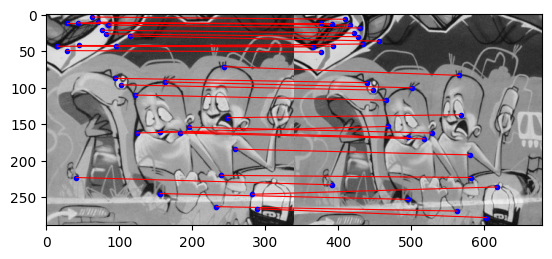

In [12]:
graf_a = cv2.imread("./data/graf/graf_a_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
graf_b = cv2.imread("./data/graf/graf_b_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0

sigma = 3
thresh = 0.003

matched_left, matched_rigth = find_matches(graf_a, graf_b, sigma, thresh)

a4_utils.display_matches(graf_a, matched_left, graf_b, matched_rigth)

Correspondences are very accurate.

c)

In [13]:
# only keep the ones that have second nearest neighbour far away
def match_ratio(descs1, descs2, r_tresh):
    matches = {}
    for i, desc1 in enumerate(descs1):
        distances = [hellinger_distance(desc1, desc2) for desc2 in descs2]
        sorted_indices = np.argsort(distances)
        nearest, second_nearest = sorted_indices[:2]
        if distances[nearest] < r_tresh * distances[second_nearest]:
            matches[i] = nearest
    return matches

def find_matches_ratio(img1, img2, sigma, thresh, r_tresh):
    _, points1 = suppressed_hessian_points(img1, sigma, thresh)
    _, points2 = suppressed_hessian_points(img2, sigma, thresh)
    
    coords1 = np.argwhere(points1 > 0)
    coords2 = np.argwhere(points2 > 0)
    
    desc1 = a4_utils.simple_descriptors(img1, coords1[:, 0], coords1[:, 1])
    desc2 = a4_utils.simple_descriptors(img2, coords2[:, 0], coords2[:, 1])
    
    lr_matches = match_ratio(desc1, desc2, r_tresh)
    rl_matches = match_ratio(desc2, desc1, r_tresh)

    symmetric_matches = []
    for idx1, idx2 in lr_matches.items():
        if idx2 in rl_matches and rl_matches[idx2] == idx1:
            symmetric_matches.append((idx1, idx2))
    
    idx1 = [i for i, _ in symmetric_matches]
    idx2 = [j for _, j in symmetric_matches]

    matched_left = coords1[np.array(idx1)][:, [1, 0]]
    matched_right = coords2[np.array(idx2)][:, [1, 0]]

    return matched_left, matched_right

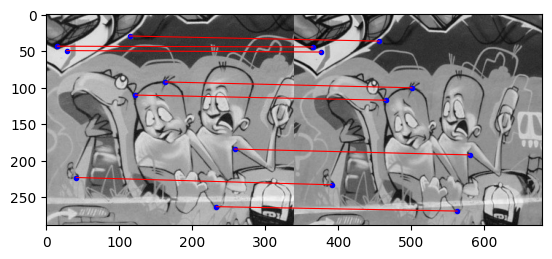

In [14]:
graf_a = cv2.imread("./data/graf/graf_a_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
graf_b = cv2.imread("./data/graf/graf_b_small.jpg", cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0

sigma = 3
thresh = 0.003
r_tresh = 0.9

matched_left, matched_rigth = find_matches_ratio(graf_a, graf_b, sigma, thresh, r_tresh)

a4_utils.display_matches(graf_a, matched_left, graf_b, matched_rigth)

d) MISSING

e)

In [27]:
def video_edge_detection():
    feature_detector = cv2.FastFeatureDetector_create()
    feature_detector.setNonmaxSuppression(15)
    feature_detector.setThreshold(15)

    video = cv2.VideoCapture("./data/video.mp4")
    frame_count = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret == True:
            key_points = feature_detector.detect(frame, None)
            cv2.imshow('video', cv2.drawKeypoints(frame, key_points, frame))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        frame_count += 1

    video.release()
    cv2.destroyAllWindows()

video_edge_detection()

KeyboardInterrupt: 

# Exercise 3

Q: Parameters p1 and p2 account for rotation (p1 = cos(fi), p2 = sin(fi)). Parameters p3 and p4 represent translation on x and y axes.

Q2:

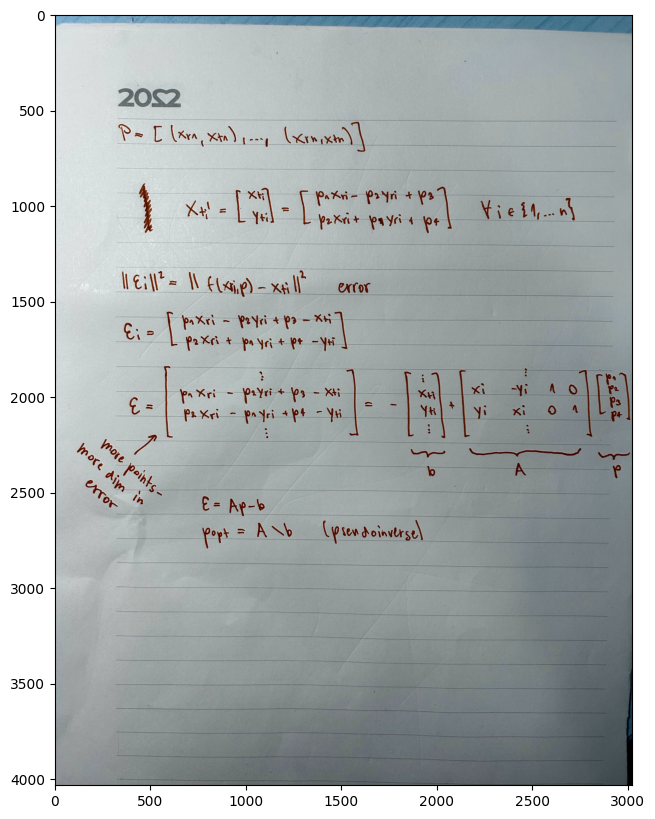

In [16]:
izpeljava = cv2.imread("./data/izpeljava.jpeg")
plt.figure(figsize=(10, 10))
plt.imshow(izpeljava)

a)

In [17]:
def estimate_homography(points1, points2):
    A = []
    for (xr, yr), (xt, yt) in zip(points1, points2):
        A.append([xr, yr, 1, 0, 0, 0, -xt*xr, -xt*yr, -xt])
        A.append([0, 0, 0, xr, yr, 1, -yt*xr, -yt*yr, -yt])
    A = np.array(A)
    
    _, _, VT = np.linalg.svd(A)
    
    # h = last column of V
    h = VT[-1, :]
    h_norm = (h / h[-1]).reshape(3, 3)
    return h_norm

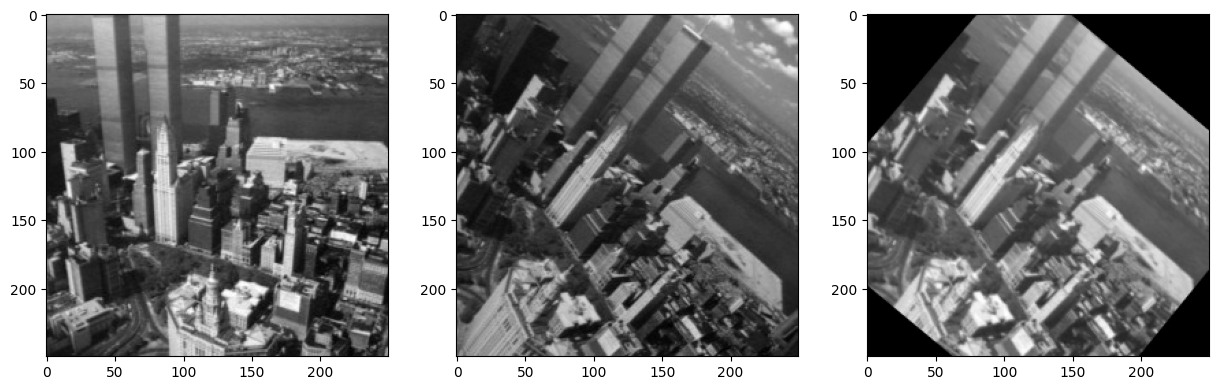

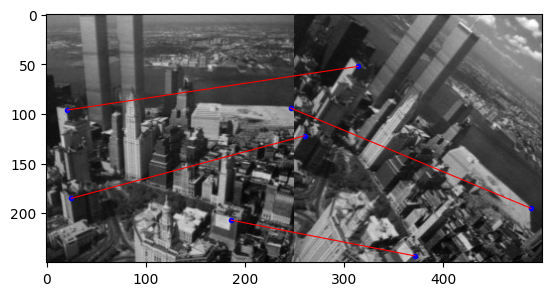

In [18]:
corr = np.loadtxt('data/newyork/newyork.txt')
points1 = corr[:, :2]
points2 = corr[:, 2:]

H = estimate_homography(points1, points2)

img1 = cv2.imread('data/newyork/newyork_a.jpg', cv2.COLOR_BGR2RGB)
img2 = cv2.imread('data/newyork/newyork_b.jpg', cv2.COLOR_BGR2RGB)

warped_image = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(warped_image, cmap="gray")
plt.show()

a4_utils.display_matches(img1, points1, img2, points2)

b)

In [19]:
# dist(proj(xr), xt)
def calculate_error(H, points1, points2):
    points1_homogeneous = np.append(points1, np.ones((points1.shape[0], 1)), axis=1)
    
    projected_points1 = (H @ points1_homogeneous.T).T
    # divide by z
    projected_points1 /= projected_points1[:, 2:3]
    errors = np.linalg.norm(projected_points1[:, :2] - points2, axis=1)
    return errors


In [20]:
def ransac_homography(matches1, matches2, n_iterations, error_threshold):
    best_inliers_count = 0
    best_H = None
    best_inliers = None
    
    for i in range(n_iterations):
        # homography is determined by 4 points
        idx = np.random.choice(len(matches1), 4, replace=False)
        selected_matches1 = matches1[idx]
        selected_matches2 = matches2[idx]
        
        # estimate homography with selected points
        H = estimate_homography(selected_matches1, selected_matches2)
        errors = calculate_error(H, matches1, matches2)
        
        inliers = errors < error_threshold
        inliers_count = np.sum(inliers)
        
        if inliers_count > best_inliers_count:
            best_inliers_count = inliers_count
            best_H = H
            best_inliers = inliers
    
    # retun the best homography
    return best_H, best_inliers

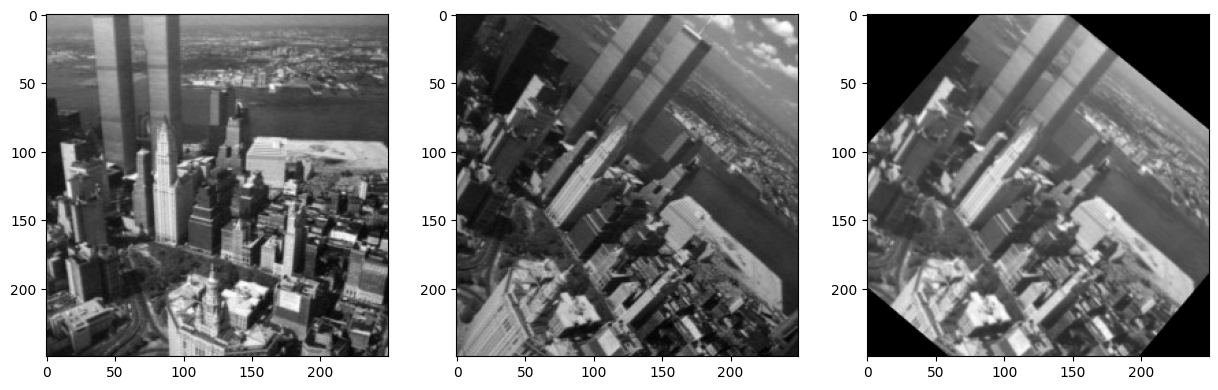

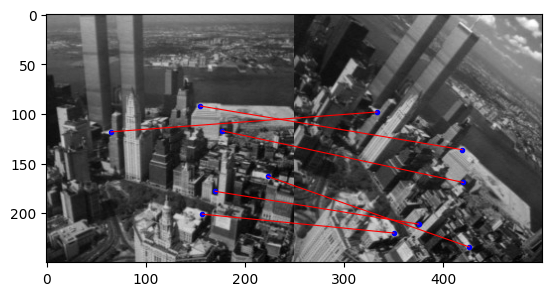

In [21]:
img1 = cv2.imread('data/newyork/newyork_a.jpg', cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
img2 = cv2.imread('data/newyork/newyork_b.jpg', cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0

matched_coords1, matched_coords2 = find_matches(img1, img2, sigma=2, thresh=0.004)

best_H, best_inliers = ransac_homography(matched_coords1, matched_coords2, n_iterations=100000, error_threshold=0.1)

warped_image1 = cv2.warpPerspective(img1, best_H, (img2.shape[1], img2.shape[0]))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(warped_image1, cmap='gray')

plt.show()

a4_utils.display_matches(img1, matched_coords1[best_inliers], img2, matched_coords2[best_inliers])

c)

In [22]:
# get average error for random choice of feature points
def get_average_w(matches1, matches2):
    N = 1000
    error_tresh = 0.1
    total_inliers = 0

    for _ in range(N):
        idx = np.random.choice(len(matches1), 4, replace=False)
        selected_matches1 = matches1[idx]
        selected_matches2 = matches2[idx]
        
        H = estimate_homography(selected_matches1, selected_matches2)
        errors = calculate_error(H, matches1, matches2)
        
        inliers = errors < error_tresh
        total_inliers += np.sum(inliers)
    return total_inliers / (len(matches1) * N)

w: 0.21173684210526317, k: 3434


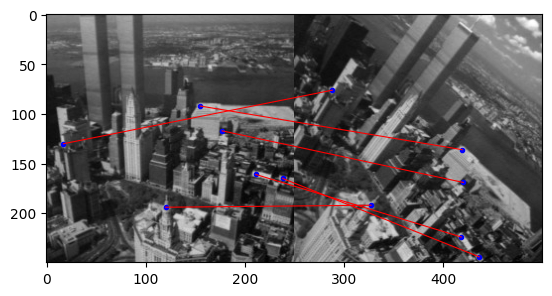

In [23]:
img1 = cv2.imread('data/newyork/newyork_a.jpg', cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
img2 = cv2.imread('data/newyork/newyork_b.jpg', cv2.IMREAD_GRAYSCALE).astype("float64") / 255.0
matched_coords1, matched_coords2 = find_matches(img1, img2, sigma=2, thresh=0.004)

w = get_average_w(matched_coords1, matched_coords2)
p_fail = 0.001
k = math.ceil(math.log(p_fail) / math.log(1 - w**4))

print(f"w: {w}, k: {k}")

best_H, best_inliers = ransac_homography(matched_coords1, matched_coords2, n_iterations=k, error_threshold=0.1)

a4_utils.display_matches(img1, matched_coords1[best_inliers], img2, matched_coords2[best_inliers])

d)

In [24]:
def warp_perspective_my(image, H):
    res = np.zeros_like(image)
    H_inv = np.linalg.inv(H)
    
    for y in range(res.shape[0]):
        for x in range(res.shape[1]):
            dest_point = H_inv @ np.array([x, y, 1])
            dest_point /= dest_point[2]
            dest_point = list(map(round, list(dest_point)))
            
            if 0 <= dest_point[0] < image.shape[1] and 0 <= dest_point[1] < image.shape[0]:
                res[y, x] = image[dest_point[1], dest_point[0]]
    return res

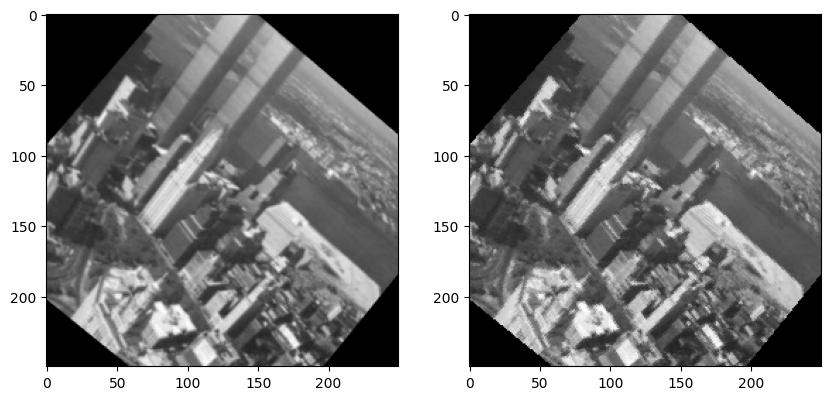

In [25]:
warped_image_cv2 = cv2.warpPerspective(img1, best_H, (img2.shape[1], img2.shape[0]))
warped_image_own = warp_perspective_my(img1, best_H)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(warped_image_cv2, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(warped_image_own, cmap='gray')